In this post I will tell you how to do statistics in Python. I've been trained in statistics mostly with R, but I do a lot of fMRI analyses in Python and do not really want to switch back and forth.

# Table of Contents
* [Intro](#Intro)
* [Prepare dataset](#Prepare-dataset)
* [Correlation](#Correlation)
* [One-sample t-test](#One-sample-t-test)
* [Independent sample t-test](#Independent-sample-t-test)
* [OLS Regression](#OLS-Regression)
* [ANOVA](#ANOVA)
* [Generalized Linear Models](#Generalized-Linear-Models)
* [Linear Mixed Effects](#Linear-Mixed-Effects)


# Intro

We will be using several Python's modules such as numpy, scipy and [statsmodels](http://statsmodels.sourceforge.net/). Numpy and scipy are standard modules. Statsmodels are shipped with [anaconda](https://www.continuum.io/downloads), but if you somehow do not have statsmodels, install them via `pip install -U statsmodels` or `easy_install -U statsmodels`. Good news is that statsmodels allow to do statistics with R-like formulas (most of the time)!

In R we often work with dataframes. In Python the dataframes are handled with [Pandas](http://pandas.pydata.org/), which by the way works fine with missing values. In case you do not have it, [install it](http://pandas.pydata.org/pandas-docs/stable/install.html)! Hint: `pip install pandas` should work ;)

Here is a [very nice tutorial on Pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html), which I have no intention to rewrite here. It explains how to handle data in timeseries, dataframes, subsetting data, reading and writing, and many more. 

# Prepare dataset

In [53]:
#set common stuff
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(threshold='nan') #to print the whole array

Here I will make up a dataset. I will use two continuous variables, as well as one variable that good for nesting and one binary variable. To make sense out of it, here are the names for these variables. One continuous variable will be liking ice cream (just because I love it!) on a scale from 0 to 100 (hate to love respectively). It may be our dependent variable. The other continuous variable: the temperature of the weather, nesting variable is for the cities where the data were collected, and the last binary variable is for having kids. Please keep in mind, I'm not going to decipher what each model told us about the variables or whether it makes sense to run them together in a model. My goal is to show that we can run a variety of models in python, and the results will be identical to an output from R.

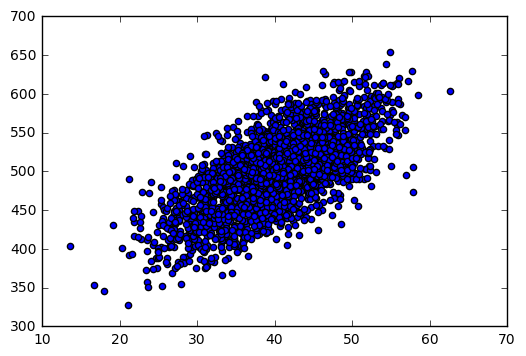

In [163]:
#generate correlated data
xx = np.array([-30.0, 110.0])
yy = np.array([0., 1000.0])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 10, yy.std() / 10]
corr = 0.7         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 2500).T
plt.scatter(m[0], m[1])

In [168]:
# categorical variable
cities = np.random.randint(0, 50, 2500,dtype='i')

# binary variable 
kids =  np.random.randint(0, 2, 2500,dtype='i')

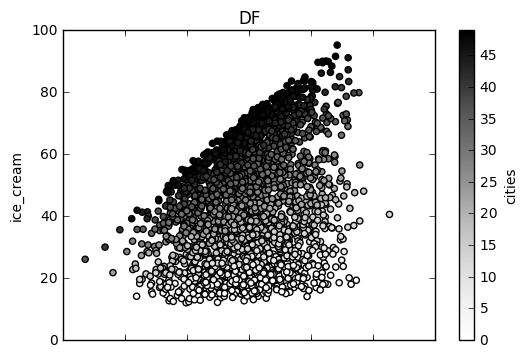

In [202]:
# Convert to Pandas. Here to make sense of all the models below, I made up some variable names.
df = pd.DataFrame({'ice_cream':m[1], 'temp': m[0], 'cities': cities, 'kids': kids})

# Assuming different cities have different preferences
for num in xrange(50):
    df['ice_cream'][df['cities']==num] += df['temp']*num

# Assuming liking ice cream is increased with kids (1; no kids = 0)
df['ice_cream'][df['kids']==1] += df['temp']*1.5

# scale
df['ice_cream'] = df['ice_cream']/35

# Here is how to plot the df
df.plot(x='temp', y='ice_cream', kind='scatter', c='cities', ax=None, subplots=False, sharex=None, sharey=False, 
        layout=None, figsize=None, use_index=True, title='DF', grid=None, legend=True, style=None, 
        logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, 
        fontsize=None, colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, sort_columns=False)


In [182]:
#Preview top few lines
df.head()

,cities,ice_cream,kids,temp
0,19,47.529669,1,57.004601
1,42,67.420913,0,42.419001
2,42,61.912708,0,39.236830
3,32,50.251380,1,38.797294
4,16,34.368304,1,41.432471


In [183]:
# Summary
df.describe()

,cities,ice_cream,kids,temp
count,2500.000000,2500.000000,2500.00000,2500.000000
mean,24.492000,42.867872,0.48960,39.899549
std,14.563366,17.665057,0.49999,6.889043
min,0.000000,12.006117,0.00000,13.531745
25%,12.000000,27.950608,0.00000,35.380744
50%,24.000000,41.268259,0.00000,39.998665
75%,38.000000,56.383082,1.00000,44.571119
max,49.000000,95.132215,1.00000,62.615418


In [175]:
# save it for replications in R
df.to_csv("~/exchange.csv")

# Correlation

In [184]:
print "Pearson correlation with Pandas"
df.corr(method='pearson') #also available ‘kendall’ and ‘spearman’

Pearson correlation with Pandas


,cities,ice_cream,kids,temp
cities,1.000000,0.926675,-0.016553,-0.044868
ice_cream,0.926675,1.000000,0.034269,0.288360
kids,-0.016553,0.034269,1.000000,-0.017963
temp,-0.044868,0.288360,-0.017963,1.000000


In [185]:
print "Pearson correlation with Numpy"
print np.corrcoef(df['ice_cream'],df['temp'])

Pearson correlation with Numpy
[[ 1.          0.28836048]
 [ 0.28836048  1.        ]]


In [186]:
print "Pearson correlation with Scipy"
r, p = sp.stats.pearsonr(df['ice_cream'],df['temp'])
print "correlation coefficient: ", r, "; p-value: ", p

Pearson correlation with Scipy
correlation coefficient:  0.28836047698 ; p-value:  4.47496022458e-49


Looks like Scipy is the only way to test for significance

# One-sample t-test

We'll be using the same dataframe from above.

In [187]:
# Using scipy
t, p = sp.stats.ttest_1samp(df['ice_cream'], popmean=0)
print "t-value: ", t, "; p-value: ", p

t-value:  121.335222203 ; p-value:  0.0


# Independent sample t-test

In [188]:
# With scipy
t, p = sp.stats.ttest_ind(df['ice_cream'],df['temp'])
print "t-value: ", t, "; p-value: ", p

t-value:  7.82751207811 ; p-value:  6.03132649935e-15


In [189]:
# With statsmodels that also give degrees of freedom
t, p, df = sm.stats.ttest_ind(df['ice_cream'],df['temp'])
print "t-value: ", t, "; p-value: ", p, "; df: ", df 

t-value:  7.82751207811 ; p-value:  6.03132649935e-15 ; df:  4998.0


In [200]:
# Statsmodels with unequal variance that is a default in R
# Using numpy arrays since df gives an error

t, p, df = sm.stats.ttest_ind(np.asarray(df['ice_cream']),np.asarray(df['temp']), 
                              alternative='two-sided', usevar='unequal') 
# alternative also accepts 'larger' and 'smaller' as one-sided indications
print "t-value: ", t, "; p-value: ", p, "; df: ", df 

t-value:  7.82751207811 ; p-value:  6.68488304875e-15 ; df:  3241.93905035


# OLS Regression

In [203]:
# Finally using an R-like formula :)
lm = smf.ols('ice_cream ~ temp',data=df).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:              ice_cream   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     226.6
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           4.47e-49
Time:                        13:12:17   Log-Likelihood:                -10617.
No. Observations:                2500   AIC:                         2.124e+04
Df Residuals:                    2498   BIC:                         2.125e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.3653      1.989      6.719      0.0

In [206]:
#Now using kids as a factor in an interaction
lm2 = smf.ols('ice_cream ~ temp * C(kids)',data=df).fit()
print lm2.summary()

                            OLS Regression Results                            
Dep. Variable:              ice_cream   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     79.05
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           7.53e-49
Time:                        13:15:08   Log-Likelihood:                -10612.
No. Observations:                2500   AIC:                         2.123e+04
Df Residuals:                    2496   BIC:                         2.126e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            17.2132      2.80

**More info** http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/ols.html

# ANOVA

In [207]:
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame
print table

                 sum_sq      df           F        PR(>F)
temp       64843.702800     1.0  226.551244  4.474960e-49
Residual  714979.828862  2498.0         NaN           NaN


# Generalized Linear Models 

In [218]:
mod1 = smf.glm('kids ~ ice_cream', data=df, family=sm.families.Binomial()).fit()
print mod1.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   kids   No. Observations:                 2500
Model:                            GLM   Df Residuals:                     2498
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1730.9
Date:                Tue, 25 Oct 2016   Deviance:                       3461.7
Time:                        13:36:46   Pearson chi2:                 2.50e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.2081      0.105     -1.979      0.048        -0.414    -0.002
ice_cream      0.0039      0.002      1.713      0.0

**More info:** http://statsmodels.sourceforge.net/stable/glm.html and http://statsmodels.sourceforge.net/devel/contrasts.html

# Linear Mixed Effects

In [179]:
# Cold ratings are nested into brands, there is only one random slople - intercept
model1 = sm.MixedLM.from_formula("ice_cream ~ temp", data=df, groups=df["cities"]).fit(reml=False)
print model1.summary()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ice_cream 
No. Observations: 2500    Method:             ML        
No. Groups:       50      Scale:              10.0311   
Min. group size:  38      Likelihood:         -6609.5008
Max. group size:  70      Converged:          Yes       
Mean group size:  50.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      8.921    2.360  3.780 0.000  4.296 13.547
temp           0.851    0.009 91.185 0.000  0.833  0.869
Intercept RE 271.356   17.322                           



In [180]:
model2 = sm.MixedLM.from_formula("ice_cream ~ temp", data=df, re_formula="temp", groups=df["cities"]).fit(reml=False)
print model2.summary()

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    ice_cream 
No. Observations:    2500       Method:                ML        
No. Groups:          50         Scale:                 1.8684    
Min. group size:     38         Likelihood:            -4551.3137
Max. group size:     70         Converged:             Yes       
Mean group size:     50.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               8.599    0.173 49.774 0.000  8.261  8.938
temp                    0.862    0.060 14.433 0.000  0.745  0.980
Intercept RE            0.151    0.412                           
Intercept RE x temp RE -0.164    0.073                           
temp RE                 0.178    0.026                           



**More info:** http://statsmodels.sourceforge.net/stable/mixed_linear.html